In [26]:
#importing libraries 

import os
import time
import json
import numpy as np
import pandas as pd
import tqdm
from openai import OpenAI
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

from dotenv import load_dotenv
load_dotenv()


True

In [27]:
# products dataset
products = [
    {"name": "Boho Dress", "desc": "Flowy maxi dress, earthy tones — bohemian festival vibes"},
    {"name": "Energetic Bomber", "desc": "Neon-trim bomber jacket, urban and confident"},
    {"name": "Cozy Knit Sweater", "desc": "Soft oversized knit for cozy home days"},
    {"name": "Tailored Blazer", "desc": "Sharp lines, office smart-casual look"},
    {"name": "Sport Luxe Leggings", "desc": "Glossy high-waist leggings for active wear"},
    {"name": "Vintage Tee", "desc": "Retro print tee with relaxed weekend style"},
    {"name": "Silk Slip Skirt", "desc": "Elegant silk skirt for soft evening vibes"},
]

df = pd.DataFrame(products)
df

,name,desc
0,Boho Dress,"Flowy maxi dress, earthy tones — bohemian fest..."
1,Energetic Bomber,"Neon-trim bomber jacket, urban and confident"
2,Cozy Knit Sweater,Soft oversized knit for cozy home days
3,Tailored Blazer,"Sharp lines, office smart-casual look"
4,Sport Luxe Leggings,Glossy high-waist leggings for active wear
5,Vintage Tee,Retro print tee with relaxed weekend style
6,Silk Slip Skirt,Elegant silk skirt for soft evening vibes


In [28]:
client = OpenAI()  

def get_embedding(text):
    # Generating embeddings using OpenAI model text-embedding-ada-002
    response = client.embeddings.create(
        model="text-embedding-ada-002",
        input=text
    )
    return response.data[0].embedding

# Create embeddings for each product description
df["embedding"] = [get_embedding(t) for t in df["desc"]]
print("Product embeddings created successfully!")

Product embeddings created successfully!


In [29]:
def vibe_matcher(query, top_k=3, threshold=0.6):
    #Embed the user query
    q_emb = np.array(get_embedding(query))
    all_emb = np.vstack(df["embedding"].values)

    #Compute cosine similarities between query and all product embeddings
    sims = cosine_similarity([q_emb], all_emb)[0]

    #Attach similarity scores to dataframe
    df_result = df.copy()
    df_result["similarity"] = sims

    #Sort by similarity (descending) and take top-k results
    top_results = df_result.sort_values("similarity", ascending=False).head(top_k)

    #Fallback handling — if best match < threshold
    best_score = top_results.iloc[0]["similarity"]
    if best_score < threshold:
        print(f" No strong match found for '{query}' (best score: {best_score:.2f})")
        print("Try a clearer vibe (e.g., 'boho summer', 'sporty urban', 'cozy minimal').")

    #Return top-k ranked results
    return top_results

In [31]:
# Testing few example vibe queries
queries = [
    "energetic urban chic",
    "cozy minimal home outfit",
    "futuristic robotic armor" 
]

for q in queries:
    print(f"\nQuery: {q}")
    top_items = vibe_matcher(q, threshold=0.83)
    for i, row in top_items.iterrows():
        print(f"{i+1}. {row['name']} — {row['desc']} (score: {row['similarity']:.3f})")


Query: energetic urban chic
2. Energetic Bomber — Neon-trim bomber jacket, urban and confident (score: 0.868)
4. Tailored Blazer — Sharp lines, office smart-casual look (score: 0.828)
6. Vintage Tee — Retro print tee with relaxed weekend style (score: 0.821)

Query: cozy minimal home outfit
3. Cozy Knit Sweater — Soft oversized knit for cozy home days (score: 0.882)
6. Vintage Tee — Retro print tee with relaxed weekend style (score: 0.836)
7. Silk Slip Skirt — Elegant silk skirt for soft evening vibes (score: 0.834)

Query: futuristic robotic armor
 No strong match found for 'futuristic robotic armor' (best score: 0.82)
Try a clearer vibe (e.g., 'boho summer', 'sporty urban', 'cozy minimal').
2. Energetic Bomber — Neon-trim bomber jacket, urban and confident (score: 0.820)
5. Sport Luxe Leggings — Glossy high-waist leggings for active wear (score: 0.789)
4. Tailored Blazer — Sharp lines, office smart-casual look (score: 0.783)



 Evaluation Results:

                      query  best_similarity  good_match  latency_sec
0      energetic urban chic         0.867548        True     0.412485
1  cozy minimal home outfit         0.882209        True     0.373403
2  futuristic robotic armor         0.820120       False     0.445138


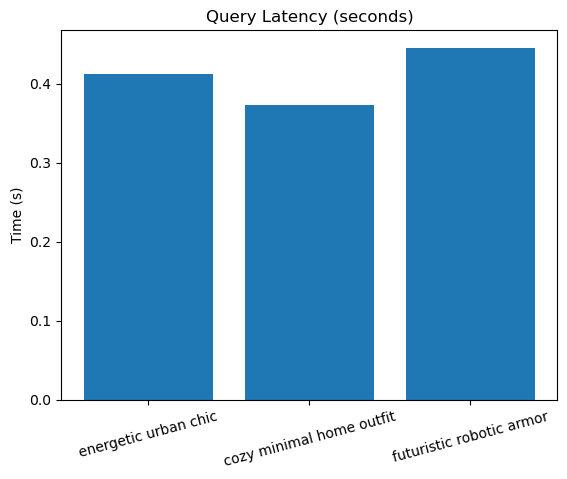

In [32]:
import time
from timeit import default_timer as timer
import matplotlib.pyplot as plt


# storing results
results = []
for q in queries:
    start = timer()
    top = vibe_matcher(q)
    end = timer()
    best = float(top["similarity"].max())
    results.append({
        "query": q,
        "best_similarity": best,
        "good_match": best > 0.85,
        "latency_sec": end - start
    })

# Display metrics
metrics_df = pd.DataFrame(results)
print("\n Evaluation Results:\n")
print(metrics_df)

# Plot latency for each query
plt.bar(metrics_df["query"], metrics_df["latency_sec"])
plt.title("Query Latency (seconds)")
plt.ylabel("Time (s)")
plt.xticks(rotation=15)
plt.show()

-- REFLECTION


- Good overall performance:
The vibe matcher correctly picked products that semantically fit each query.
For example, “energetic urban chic” mapped to the bomber jacket,while “cozy minimal home outfit” matched the sweater showing that OpenAI’s embeddings captured the mood behind each phrase, not just keywords.

- Edge-case handling:
When a query didn’t clearly relate to any product after increasing the good match threshold (“futuristic robotic armor”), the system printed a fallback message instead of returning irrelevant results.
This makes the experience more natural, close to accurate and user-friendly.

- Improvements for the future:
I would integrate a vector database like Pinecone so embeddings can be searched quickly and scaled to thousands of products.
Adding a reranker or cross-encoder could also refine the final top-3 recommendations for higher accuracy.

- Potential feature ideas:
Combine multiple fields (title + description + tags) into one embedding, let users give thumbs-up feedback to fine-tune results, and cache embeddings locally to reduce API latency.